In [41]:
import torch
from torch import nn

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
    
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 28 * 28),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.model(x)

In [42]:
from torchvision import datasets, transforms
from torch import optim
from torch.utils.data import ConcatDataset, DataLoader

EPOCHS = 200
BATCH_SIZE = 128
LATENT_DIM = 128

transform = transforms.Compose([
    transforms.ToTensor(),                         # (1, 28, 28)
    transforms.Normalize(mean=(0.5,), std=(0.5,)), # [-1, 1]
    transforms.Lambda(lambda x: x.view(-1))        # (28 * 28,)
])
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
dataset = ConcatDataset([train_dataset, test_dataset])
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

discriminator = Discriminator().to(device)
generator = Generator(LATENT_DIM).to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4)

In [ ]:
import os
from tqdm import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

FIXED_NOISE = torch.randn(25, LATENT_DIM).to(device)
SAVE_DIR = "gen_images/mnist_gan"

os.makedirs(SAVE_DIR, exist_ok=True)

def save_generated_images(generator, epoch, fixed_noise):
    generator.eval()
    with torch.no_grad():
        gen_imgs = generator(fixed_noise)

        # [-1,1] -> [0,1]
        gen_imgs = (gen_imgs + 1) / 2
        gen_imgs = gen_imgs.view(-1, 1, 28, 28)

        grid = make_grid(gen_imgs, nrow=5)

    grid = grid.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(5, 5))
    plt.imshow(grid, cmap="gray")
    plt.axis("off")

    plt.text(
        0.5, -0.05,
        f"Epoch {epoch}",
        fontsize=12,
        ha="center",
        transform=plt.gca().transAxes
    )

    plt.savefig(f"{SAVE_DIR}/epoch_{epoch:03d}.png", bbox_inches="tight")
    plt.close()

    generator.train()

loss_fn = nn.BCELoss()

g_losses, d_losses = [], []
for epoch in range(EPOCHS):

    discriminator.train()
    generator.train()
    
    epoch_g_loss, epoch_d_loss = [], []

    with tqdm(data_loader, unit="batch", desc=f"Epoch #{epoch+1}") as pbar:
        for real_imgs, _ in pbar:
            real_imgs = real_imgs.to(device)

            valid = torch.ones(real_imgs.size(0), 1).to(device)
            fake = torch.zeros(real_imgs.size(0), 1).to(device)

            z = torch.randn(real_imgs.size(0), LATENT_DIM).to(device)
            gen_imgs = generator(z)

            g_loss = loss_fn(discriminator(gen_imgs), valid)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_loss = loss_fn(discriminator(real_imgs), valid)
            d_loss += loss_fn(discriminator(gen_imgs.detach()), fake)

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            epoch_g_loss.append(g_loss.item())
            epoch_d_loss.append(d_loss.item())


            pbar.set_postfix({
                'Avg Gen. Loss': f'{sum(epoch_g_loss) / len(epoch_g_loss):.4f}',
                'Avg Disc. Loss': f'{sum(epoch_d_loss) / len(epoch_d_loss):.4f}'
            })
    save_generated_images(generator, epoch + 1, FIXED_NOISE)

    g_losses += epoch_g_loss
    d_losses += epoch_d_loss

Epoch #200: 100%|██████████| 547/547 [00:09<00:00, 59.36batch/s, Avg Gen. Loss=1.4804, Avg Disc. Loss=0.9557]


In [44]:
torch.save(generator.state_dict(), "models/gen_gan.pt")
torch.save(discriminator.state_dict(), "models/disc_gan.pt")

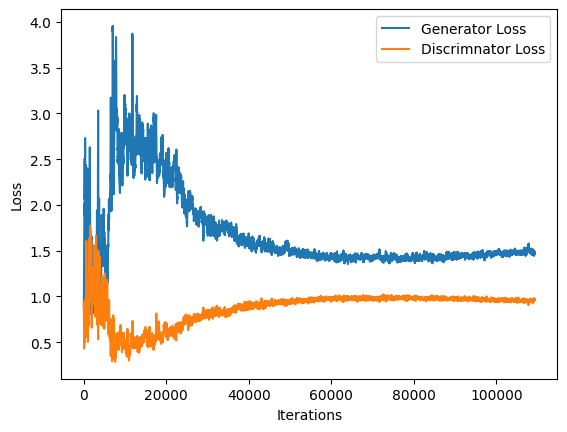

In [49]:
import numpy as np
from matplotlib import pyplot as plt


def plot_losses(g_losses, d_losses, window=1):
    weights = np.ones(window) / window
    
    fig, ax = plt.subplots()
    ax.plot(
        np.convolve(g_losses, weights, mode='valid'),
        label="Generator Loss"
    )
    ax.plot(
        np.convolve(d_losses, weights, mode='valid'),
        label="Discrimnator Loss"
    )
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()

    return fig, ax

fig, ax = plot_losses(g_losses, d_losses, window=100)

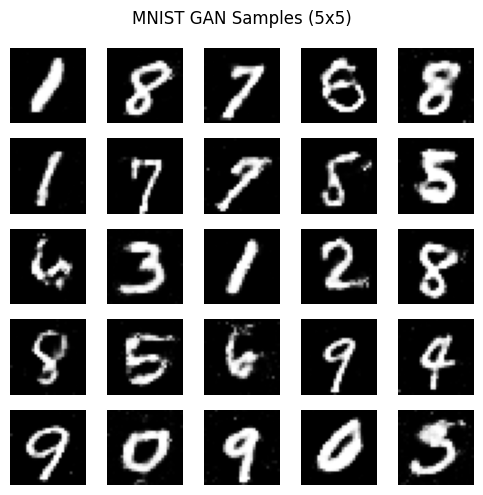

In [50]:
from matplotlib import pyplot as plt

n = 5

def plot_samples(samples, n=5):
    fig = plt.figure(figsize=(n, n))

    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.imshow(samples[i], cmap="gray")
        plt.axis("off")

    plt.suptitle(f"MNIST GAN Samples ({n}x{n})")
    plt.tight_layout()
    
    return fig


with torch.no_grad():
    z = torch.randn(n * n, LATENT_DIM).to(device)
    samples = generator(z)

fig = plot_samples(
    samples.view(-1, 28, 28).cpu().detach(),
    n=n
)

In [59]:
import imageio.v2 as imageio
import os

folder = "gen_images/mnist_gan"

images = []

files = sorted(
    [f for f in os.listdir(folder) if f.endswith(".png")]
)

for file in files:
    img_path = os.path.join(folder, file)
    images.append(imageio.imread(img_path))

imageio.mimsave("gen_images//mnist_gan/training.gif", images, fps=20)